In [1]:
%matplotlib ipympl

In [2]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipyleaflet import Map, Polyline, Marker, Popup, basemaps, WidgetControl
from IPython.display import display, clear_output

In [3]:
output_widget_compare = widgets.Output()
output_widget_fetch_data = widgets.Output()
output_widget_plot_all = widgets.Output()
output_widget_plot_selected = widgets.Output()

In [4]:
# Function to update the output widget with the plot
def update_output(fig, output_widget):
    with output_widget:
        clear_output(wait=True)
        display(fig)

In [5]:


def compareAirports(airports):
    con = sql.connect("flights.db")
    fig, ax = plt.subplots(figsize=(12, 6))

    for airport in airports:
        airport_param = " " + airport.strip() + " "
        query = "SELECT Time, No FROM flight_data WHERE Type='PAS' AND Airport=? AND AMOUNT = 'Total' ORDER BY Time"
        df = pd.read_sql_query(query, con, params=[airport_param])
        df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m', errors='coerce')

        if df.empty:
            print(f"No data available for airport: {airport}")
            continue

        ax.plot(df['Time'], df['No'], label=airport)

    con.close()
    
    ax.set_title('Passenger Data Comparison', fontsize=18)
    ax.set_ylabel('# Passengers', fontsize=16)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis='both', labelsize=14)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(title = "Destination Airport(s)", loc='center left', bbox_to_anchor=(1, 0.5))
    
    update_output(fig, output_widget_compare)

In [6]:
# Function to generate a DataFrame containing time and number columns for a given airport
def getPASAir1(airport):
    con = sql.connect("flights.db")
    # Add spaces before and after the airport name
    airport_param = " " + airport.strip() + " "
    query = "SELECT Time, No FROM flight_data WHERE Type='PAS' AND Airport=? AND AMOUNT = 'Total' ORDER BY Time"
    df1 = pd.read_sql_query(query, con, params=[airport_param])
    con.close()

    if df1.empty:
        print(f"No data available for airport: {airport}")
        return
   

    df1['Time'] = pd.to_datetime(df1['Time'], format='%Y-%m', errors='coerce')
    if df1['Time'].isnull().any():
        print("Some dates were not parsed correctly")

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df1['Time'], df1['No'])
    plt.title(f'Route from DUBLIN to {airport}', fontsize=18)
    ax.set_ylabel('# Passengers', fontsize=16)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis='both', labelsize=14)
    plt.tight_layout()
    update_output(fig, output_widget_fetch_data)


In [7]:
def plot_all(airport):
    con = sql.connect("flights.db")
    # Add spaces before and after the airport name
   
    query = "SELECT Airport, Time, No FROM flight_data WHERE Type='PAS' AND AMOUNT = 'Total' ORDER BY Time"
    df1 = pd.read_sql_query(query, con)
    con.close()

    if df1.empty:
        print(f"No data available for airport: {airport}")
        return
    

    df1['Time'] = pd.to_datetime(df1['Time'], format='%Y-%m', errors='coerce')
    if df1['Time'].isnull().any():
        print("Some dates were not parsed correctly")
        
    fig, ax = plt.subplots(figsize=(12, 6))

    for airport in df1['Airport'].unique():
        airport_df = df1[df1['Airport'] == airport]
        ax.plot(airport_df['Time'], airport_df['No'], label=airport.strip())

    plt.title('Passenger Data for All Airports', fontsize=18)
    ax.set_ylabel('# Passengers', fontsize=16)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis='both', labelsize=14)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(title = "Destination Airport(s)", loc='center left', bbox_to_anchor=(1, 0.5))
    update_output(fig, output_widget_plot_all)

In [8]:
# Connect to the SQLite database
conn = sql.connect('flights.db')
cur = conn.cursor()

# Select the required columns from the airport_data table
query = "SELECT Airport, lat_decimal, lon_decimal FROM airport_data;"
cur.execute(query)
all_destinations_data = cur.fetchall()

# Close the connection to the database
conn.close()


In [9]:
# Convert the results into a DataFrame
flights_df = pd.DataFrame(all_destinations_data, columns=['Airport', 'lat_decimal', 'lon_decimal'])

# Coordinates for Dublin
dublin_coords = (53.4268, -6.2562)

# Initialize the map centered at Dublin
m = Map(center=dublin_coords, zoom=6, basemap=basemaps.OpenStreetMap.Mapnik) 

selected_airports = {}

def create_polyline(airport, coordinates):
    polyline = Polyline(locations=coordinates, color="blue", fill=False)
    hover_popup = Popup(location=coordinates[-1], child=widgets.HTML(value=f"<b>{airport}</b>"), close_button=False, auto_close=False)
    polyline.popup = hover_popup

    def on_click(event=None, properties=None, **args):
        if airport not in selected_airports:
            selected_airports[airport] = polyline
            polyline.color = "red"  # Change color to indicate selection
        else:
            # Deselect and revert color
            del selected_airports[airport]
            polyline.color = "blue"
        print(f"Selected Airports: {list(selected_airports.keys())}")

    polyline.on_click(on_click)
    return polyline

In [10]:
def plot_selected_airports(b):
    clear_output(wait=True)
    if selected_airports:
        compareAirports(selected_airports)
    else:
        print("No airports selected.")
    display(m)
    display(num_airports_slider)
    display(airport_select)
    display(plot_button)

plot_button = widgets.Button(description="Plot Selected Airports")
plot_button.on_click(plot_selected_airports)

# Function to update the map based on the selected airports
def update_map(selected_airports):
    m.layers = [m.layers[0]]  # Reset to only keep the base layer

    # Add marker for Dublin
    dublin_marker = Marker(location=dublin_coords)
    m.add_layer(dublin_marker)

    # Add flight paths with popups
    for airport in selected_airports:
        airport_data = flights_df[flights_df['Airport'] == airport]
        for _, row in airport_data.iterrows():
            path = [(dublin_coords[0], dublin_coords[1]), (row['lat_decimal'], row['lon_decimal'])]
            polyline = create_polyline(airport, path)
            m.add_layer(polyline)

Map(bottom=5460.0, center=[54.00776876193478, 9.140625000000002], controls=(ZoomControl(options=['position', '…

IntSlider(value=21, continuous_update=False, description='Number of Airports:', max=89, min=1)

SelectMultiple(description='Airports:', index=(0,), options=('KEFLAVIK', 'BRUSSELS', 'CHARLEROI/BRUSSELS SOUTH…

Button(description='Plot Selected Airports', style=ButtonStyle())

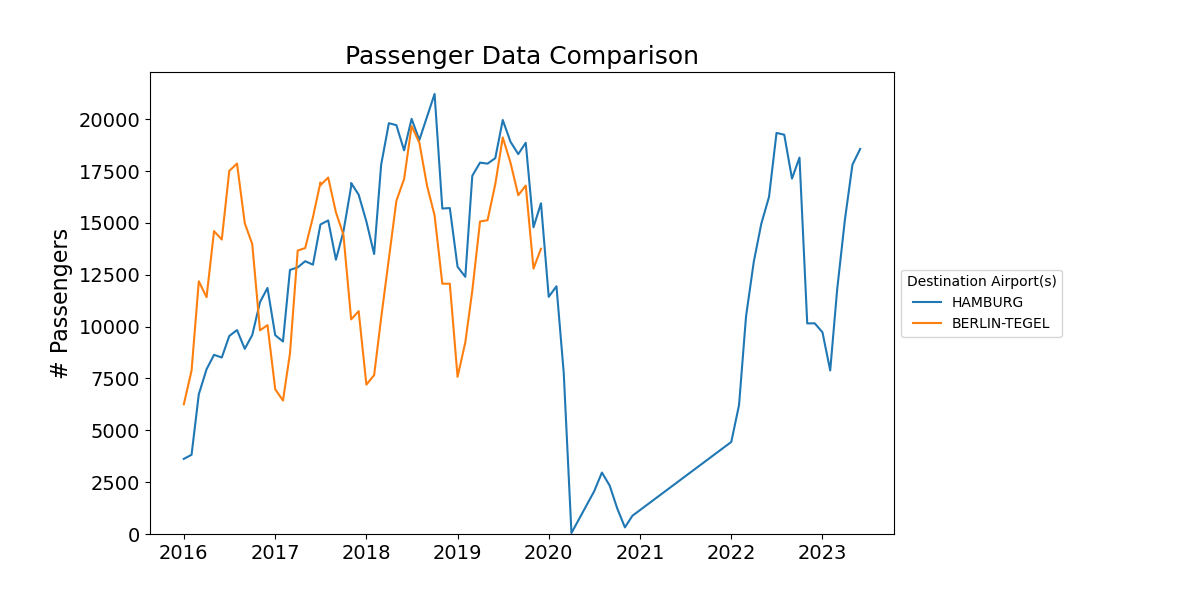

In [11]:
# Create a slider widget for selecting the number of airports
num_airports_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=len(flights_df),
    step=1,
    description='Number of Airports:',
    continuous_update=False
)

# Create a dropdown menu for selecting specific airports
airport_select = widgets.SelectMultiple(
    options=flights_df['Airport'].unique().tolist(),
    value=[flights_df['Airport'].unique()[0]],
    description='Airports:',
    disabled=False
)

# Link the slider and the dropdown menu to the update function
def on_slider_change(change):
    selected_airports = flights_df['Airport'].unique()[:change['new']]
    update_map(selected_airports)

def on_airport_change(change):
    update_map(change['new'])
    
def plot_selected_airports(b):
    clear_output(wait=True)
    if selected_airports:
        compareAirports(selected_airports)
    else:
        print("No airports selected.")
    display(m)
    display(num_airports_slider)
    display(airport_select)
    display(plot_button)

plot_all_button = widgets.Button(description="Plot all Airports")
plot_all_button.on_click(plot_all)
plot_button = widgets.Button(description="Plot Selected Airports")
plot_button.on_click(plot_selected_airports)

num_airports_slider.observe(on_slider_change, names='value')
airport_select.observe(on_airport_change, names='value')

# Display the map, slider, dropdown menu, and plot button
display(m)
display(num_airports_slider)
display(airport_select)
display(plot_button)
display(plot_all_button)
display(output_widget_compare)
display(output_widget_fetch_data)
display(output_widget_plot_all)
display(output_widget_plot_selected)